# Exploring the Data Space of the Space Data Explorers

_In this notebook we will use the Twitter API to explore the conversation happening on Twitter related to NASA and Space Apps. We will be looking at a collection of tweets from recorded esporadically between Thursday night (before the first all-women spacewalk!) till now._

Questions we'll try to answer:

1) *What is the sentiment of the conversation?*

2) *What's the conversation about? *

3) *Can we build a few profiles based on information provided by users in their description?*

4) *Where (in the physical world) are people tweeting from and of those locations which ones have a higher engagement?*

##### You can find the code at https://github.com/nelabdiel/EtDSofSDE

In [1]:
import pandas as pd
import scipy as sp
import random as rdm
import requests  # better than the urllib libraries
import simplejson
from requests_oauthlib import OAuth1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from textblob import TextBlob
import heapq
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from itertools import islice, chain
from IPython.display import Image
from IPython import display
import matplotlib.pylab as plt
%matplotlib inline
import pysal as ps
from pysal.contrib.viz import mapping as maps
from pylab import *

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

import sys
from twython import Twython
import os
from datetime import datetime


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### We need twitter credentials in order to use the API. For more info on how to obtain them go to https://developer.twitter.com/en/docs

In [3]:
with open("../twitter_secrets2.json.nogit") as fh:
    secrets = simplejson.loads(fh.read())


auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

# Let's create a function to request the posts we are interested in.

In [573]:
#L = []

def tweet_generator():
    """ Generator that live streams tweets (see 'yield' keyword)"""
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                           auth=auth, 
                           stream=True,
                           data={"track":["nasa", 
                                          "@nasa",
                                          "#nasa",
                                          "#spaceappschallenge", 
                                          "space apps",
                                          "#spaceapps",
                                          "@spaceapps",
                                          "@spaceappsCLE"
                                          
                                         ]#, 
                                 #"languages":"en"#
                                })
    
    for line in stream.iter_lines():
        if not line:  # filter out keep-alive new lines
            continue
        tweet = simplejson.loads(line)
        if ('text' in tweet):
            L.append(tweet)
            yield tweet['text']

### Let's use that function to get a 1000 tweets!

In [575]:
c = 0
for tweet in islice(tweet_generator(), 1000):
    c += 1
    if c % 100 == 0:
        print('\n')
        print(c)
        print('\n')
    print(tweet)

@jxcxbe_c nasa site rin yon lol
#Elon | Elon Musk's Pot Smoking Cost NASA $5M | via https://t.co/eoeEKgcy81 - #Pot https://t.co/clh1wyQfso
RT @ScienceConnect2: NASA Astronauts Conduct First All-Women Space Walk - https://t.co/fSOb9xHRUX
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
Nice üëçüë©‚ÄçüöÄüë©‚ÄçüöÄ
Maybe the world is ready now for a female-lead "Space Truckers 2" movie, don't you think‚Ä¶ https://t.co/drrR40silc
RT @ringring_174455: ‰ªäÊµÅË°å„Çäüí´„ÅÆË¶ã„ÅõÂêà„ÅÑ„Ç™„Éä„Éã„Éº„ÅåüíèÊ≠ª„Å¨„Åª„Å©Êäú„Åë„ÇãÔΩóÔΩóÔΩóüí¶üí¶üí¶

„ÅÑ„Å£„Å±„ÅÑÂ∞ÑÁ≤æüí¶„Åó„Åü„Çâ„É°„ÉÉ„ÉÅ„É£Âñú„Çì„Åß„Åè„Çå„ÅüüòÇüíï

„Ç≥„Ç≥üëâ https://t.co/dC5ZzAl5kf

„ÉÅ„É≥„ÉÅ„É≥üëÉüèæË¶ã„Åõ„Åü„Å†„Åë„ÅßüíßÊø°„ÇåÂßã„ÇÅ„Å¶„Åü„ÇèÔΩóÔΩóÔΩóüòúüíó
RT @gilingero: bestest girl. &lt;3 mabait? maganda? matalino? you name it, nasa kanya.

[@cereserose] https://t.co/088qPvdH70
#RT @techinsider: We attempted to track

RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
nasa huli talaga anh ending
RT @sahith_dxb: Along with Mr. Dunay Badirkhanov ‚Äì (Vice Chairman/CTO of Azercosmos), Prof. Anne Verbiscer ‚Äì (PI on NASA Cassini Data Analy‚Ä¶
RT @PauloArguelles1: Sa'yo na nasasaktan ngayon
Sa'yo na nasusugatan ngayon
Sa'yo na may pinagdadaanan ngayon
Sa'yo na nasa sitwasyon mo ng‚Ä¶
@HillaryClinton It is a pity, the NASA has not taken you. This was unfair. It would better have been for us everybo‚Ä¶ https://t.co/PXTdyABxvf
RT @afpbbcom: Âè≤‰∏äÂàù„ÄÅÂ•≥ÊÄß„ÅÆ„Åø„ÅÆÂÆáÂÆôÈÅäÊ≥≥„ÇíÂÆüÊñΩ Á±≥„ÅÆ2È£õË°åÂ£´
https://t.co/tdrMbv8KOI
ÂõΩÈöõÂÆáÂÆô„Çπ„ÉÜ„Éº„Ç∑„Éß„É≥ÔºàISSÔºâ„Åß18Êó•„ÄÅÁ±≥Ëà™Á©∫ÂÆáÂÆôÂ±ÄÔºàNASAÔºâ„ÅÆ„ÇØ„É™„Çπ„ÉÜ„Ç£„Éº„Éä„Éª„Ç≥„ÉÉ„ÇØÈ£õË°åÂ£´„Å®„Ç∏„Çß„Ç∑„Ç´„Éª„É°„Ç§„É§„ÉºÈ£õË°åÂ£´„Åå„ÄÅÂè≤‰∏äÂàù„ÅÆÂ•≥ÊÄß„ÅÆ„Åø„Å´„Çà„ÇãÂÆáÂÆôÈÅäÊ≥≥‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @Joulmusique: Le temps de rafra√Æ

RT @DLorania: Nasa Top trends a din,siya waiting nalang sa mga Big Account 

#MMKTheYamyamStory 

@gucong_yamyam 
@MMKOfficial https://t.co‚Ä¶
Ovo je bilo nas preCednik ... ovo zivi na Dedinju ... ovo je drzalo govor ginekolozima ... ovo je nasa slika i pril‚Ä¶ https://t.co/tQgnUWKMXv
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @cicilavraie: trop dr√¥le les mecs en commentaires qui ironisent sur la vaisselle &amp; le m√©nage alors qu'√† 25 ans ils savent pas laver leur‚Ä¶
RT @RemediosFdez: Hoy, a las 17 horas desde @LaJaqueria participaremos en el  @spaceappsalm con una charla + taller de #Arduino en #ElCable‚Ä¶
RT @NASA: This week:

üë©‚ÄçüöÄüë©‚ÄçüöÄ @Astro_Christina &amp; @Astro_Jessica make history #AllWomanSpacewalk
üåî New spacesuits for #Artemis generation ast‚Ä¶
GAGU NAPRESSURE AKO KANINA MAY NAGCHAT SAKIN SINO SINO NA KAMI NASA SCHOOL PUTA NAKALIMUTAN KO PANGALAN NUNG

La #Gemini4 fue una misi√≥n espacial tripulada del programa Gemini de la #NASA, realizada en 1965.
RT @jondaly: Two women floating in space were forced to talk to a rapist. https://t.co/IAAXXUqpID
RT @ECMcLaughlin: Scroll to 2:00 minutes and watch what happens.

Because, you know, the President flipping off a female astronaut in space‚Ä¶
#*****snaptheball @FranceRugby @RugbyWorldCupFR @ClemSarlat #allonsrider (tout comme en #meeting @BMWGroup üçª) üèâüíáüóªüçπüèÅ‚Ä¶ https://t.co/rHDiiuF8Rz
@carissa_talens Baka nasa sinapupunan pa HAHAHAHA
RT @cosmosapiens_: El 18 de octubre de 1989 fue lanzada la sonda espacial Galileo de la NASA.
Su misi√≥n constaba en estudiar a J√∫piter y a‚Ä¶
RT @USArmy: From the @WestPoint_USMA Parachute Team to the International Space Station, Jeff Williams was ready to enter into the void. 

R‚Ä¶
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @MSNBC: WATC

@jhendskierhexy1 Ayain nyo lang ako please hahahhaa nasa dorm lang ako
RT @cicilavraie: trop dr√¥le les mecs en commentaires qui ironisent sur la vaisselle &amp; le m√©nage alors qu'√† 25 ans ils savent pas laver leur‚Ä¶
@YlaganRoi Ehem nasa Batangas na ako nun.
RT @DailynZona8: La pr√≥xima caminata
ser√° a la Luna
 y yo quiero traerte
una galaxia,
una peque√±a y linda
sin agujeros negros,
para que no‚Ä¶
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF


300


RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @jenserenity27: @Batty_Simba @gucong_yamyam Syempre buuin na rin natin ang team LAYF bhe! Inspiring din ang n

RT @gavinnaylor: If this isn't sobering, I don't know what is....... https://t.co/ToGA8WuKl1
un jour √ßa seras aussi anecdotique que de dire 
"pour la premi√®re fois la NASA envoie 2 personnes daltoniennes en s‚Ä¶ https://t.co/bUSCfQHJVN
POTA ANO NA CHANBAEK ANG HAROT HAROT NYO PAG NASA JAPAN KAYO KUNG KELAN BAWAL PHONES!!!!!!!
RT @WhiteHouse: "Please stand by for a call from the President of the United States." 

Congratulations to @NASA astronauts @Astro_Christin‚Ä¶
RT @dexter102111: Narito, ako'y madaling pumaparito; at ang aking ganting-pala ay nasa akin, upang bigyan ng kagantihan ang bawa't isa ayon‚Ä¶
hinablot lang ako nina tita diko alam kung san kami pupunta nasa tayabas na kami.
RT @MarleneSchiappa: üöÄüöÄ Un petit pas pour les femmes, un grand pas pour l‚Äôhumanit√© ;)
Bravo Mesdames ! #Nasa #RoleModels #Spacewalk 
Cc @ng‚Ä¶
RT @SpeakerPelosi: .@NASA has captured the imaginations of the world for generations. Congratulations to @Astro_Christina &amp; @Astro_Jessica‚Ä¶
RT @

RT @yammy_lyn: Nakita ko nasa top trends siya sana lumabas siya sa philippine trend.

#MMKTheYamyamStory https://t.co/3ZApYQOoj8
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @Space_Station: Spacewalkers @Astro_Christina and @Astro_Jessica are outside in the vacuum of space getting their tools ready to replace‚Ä¶
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
@andreadawnrp Barbie Rapunzel. God if I had her paintbrush nasa ibang bansa na sana ako ngayon.
Akala lagi nagsisinungaling. Nakakapagod na kaya kung kayo kaya nasa kalagayan ko!!
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @WhiteHouse: "Please stand by for a call from the President of the United States." 

Congratulations to @NASA astronauts @Astro_Christin‚Ä¶
RT @KamalaHar

happy ko pero wala lage ko ni glow up like ngano
@uwe_potato Nasa patatas.
RT @liezlibarra1: Mukhang naunahan ng katapangan ! Ano na Boss Gino ?!nasa Mindanao ka na ei....ahahahaha 

NCCDavaoM&amp;Gwith KIANO

 https:/‚Ä¶
How can so many believe the financial markets will suffer if this nut job is not re-elected?
@tmarks11 @HillaryClinton Fun fact, Hillary Clinton wasn't studying law as a little girl. It is impossible to know‚Ä¶ https://t.co/HjuLPYv5hZ
RT @Anggelele: Kala mo nasa Baguio kung mag inarteü§¶‚Äç‚ôÄÔ∏è HSHAHAHAHA https://t.co/MMQjSXrifa
NASA's Hubble space telescope just took incredible photos of a visiting comet from another star system https://t.co/O7LCoQ5xIz
RT @viewsfrance: Aujourd‚Äôhui, et apr√®s 50 ans de sorties spatiales masculines, la NASA s‚Äôappr√™te √† r√©aliser pour la 1√®re fois une sortie sp‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace no

RT @DLorania: Nasa Top trends a din,siya waiting nalang sa mga Big Account 

#MMKTheYamyamStory 

@gucong_yamyam 
@MMKOfficial https://t.co‚Ä¶
RT @YourMajo: Sana nasa tabi kita
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @WhipClyburn: Congratulations to NASA astronauts Jessica Meir and Christina Koch on completing the first-ever all-women spacewalk today!‚Ä¶
RT @AFPusa: Pour la premi√®re fois, deux femmes sortent dans l'espace ensemble (Nasa TV) #AFP
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @ismailsaymaz: Kadƒ±nlar ilk kez yanlarƒ±nda erkekler olmadan uzay y√ºr√ºy√º≈ü√º yaptƒ±. Hayrettin Karaman, C√ºbbeli Ahmet, Nurettin Yƒ±ldƒ±z ve ƒ∞h‚Ä¶
Remember when she was a little girl ? https://t.co/t3OHhTgb66
RT @nevsinmengu: Kocasƒ±na kahvaltƒ± hazƒ±rlamak varken uzaya √ßƒ±kmƒ±≈ü cƒ±kcƒ±kcƒ±k

Les r√©ponses c‚Äôest comme par hasard TOUS des HOMM*S.
RT @CarlosSimancas: Lying sack of shit.

#CrookedHillary https://t.co/NnJeM9Xf6Y
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @ismailsaymaz: Kadƒ±nlar ilk kez yanlarƒ±nda erkekler olmadan uzay y√ºr√ºy√º≈ü√º yaptƒ±. Hayrettin Karaman, C√ºbbeli Ahmet, Nurettin Yƒ±ldƒ±z ve ƒ∞h‚Ä¶
RT @Kris_Sacrebleu: Why is @IvankaTrump there when she couldn‚Äôt even get a security clearance without her daddy‚Äôs intervention due to HIGHL‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @ismailsaymaz: Kadƒ±nlar ilk kez yanlarƒ±nda erkekler olmadan uzay y√ºr√ºy√º≈ü√º yaptƒ±. Hayrettin Karaman, C√ºbbeli Ahmet, Nurettin Yƒ±ldƒ±z ve ƒ∞h‚Ä¶
RT @lemondefr: Les astronautes de la NASA Christina Koch et Jessica Meir s‚Äôappr√™tent √† r√©aliser la premi√®re sortie enti√®rement f√©minine ven‚Ä¶
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. 

@rmalgr nasa manila tayo pero cebu yung shirt niya
@KIANO4ever6 jusko Gino anuna...hawak na boss hahhahha nasa Mindanao ka

NCCCDavaoM&amp;Gwith KIANO
RT @obianuju: Can you show us a copy of the letter they wrote back to you?

Or did they email you the response?
Did you delete it? https://‚Ä¶
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
GAGI KAHIT NASA BACOOR AKO UMAABOT PARIN YUNG CHIKA NG MGA KAIBIGAN KO HAHAHHAHA
RT @norde_leouf: √áa tombe bien y'a beaucoup de poussi√®res sur la lune https://t.co/cxAja6dMaZ
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. Today, @Astro_Jessica brought that number up to 15 as she flo‚Ä¶
RT @cicilavraie: trop dr√¥le les mecs en commentaires qui ironisent sur la vaisselle &amp; le m√©nage alors qu'√† 25 ans ils savent pas laver leur‚Ä¶
https://t.co/vS8hzN2IGh
RT @MSNBC: WATCH: During live spacewalk call today, NASA astronau

RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @viewsfrance: Aujourd‚Äôhui, et apr√®s 50 ans de sorties spatiales masculines, la NASA s‚Äôappr√™te √† r√©aliser pour la 1√®re fois une sortie sp‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
@HillaryClinton Now we all know @HillaryClinton is lying about this, right? Yesterday I wrote a letter to NASA aski‚Ä¶ https://t.co/XIPgGMhrA3
@AndrewAQLD @4URThoughtsAust If this story were true, She would must have been at least 12 at the time - that's the‚Ä¶ https://t.co/PmES78Gh5L
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the‚Ä¶
RT @viewsfrance: Aujourd‚Äôhui, et apr√®s 50 ans de sorties spatiales masculines, la NASA s‚Äôappr√™te √† r√©aliser pour la 1√®re fois une sortie sp‚Ä¶
RT @padillacathh: ‚ÄúIba talaga g

RT @Juventusch1: https://t.co/Mj9JdcMYTn https://t.co/vS8hzN2IGh
Hi, nasa cr ako ngayon sklrüòÇ
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @fabbrdn: Mdrrr y‚Äôa autant de poussi√®re que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @BosoSpotlight: PART 1: Pagdating ko, tahimik ang bahay. Kaya pala si insan nasa kwarto. May ginagawang exercise. Burat exercise. ‚úäüí¶üí¶üí¶‚Ä¶
RT @padillacathh: ‚ÄúIba talaga glow up pag nasa tamang tao ka‚Äù

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI‚Ä¶
RT @MSorsorov: Ovo je bilo nas preCednik ... ovo zivi na Dedinju ... ovo je drzalo govor ginekolozima ... ovo je nasa slika i pr

RT @nevsinmengu: Kocasƒ±na kahvaltƒ± hazƒ±rlamak varken uzaya √ßƒ±kmƒ±≈ü cƒ±kcƒ±kcƒ±k https://t.co/CSTkOiRuxh
@IanDunt Imagine @NASA saying that to achieve the moon landing, or landing a rover on mars...
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
ÂÖàÊó•„ÄÅH&amp;M„ÅßË≤∑„Å£„ÅüNASA„ÅÆ„Éë„Éº„Ç´„Éº„ÄÇ
‰Ωú„Çä„Åå„Ç∑„Éß„Éú„Åè„Å¶Ëêé„Åà„Çãüòî
RT @TRODRAWLE: Pourtant y‚Äôa pas d‚Äôenfants √† garder dans l‚Äôespace non ? https://t.co/G0LglRn8R4
RT @WomenNASA: Today, @NASA_Astronauts and best friends @Astro_Christina and @Astro_Jessica embarked on the very first #AllWomanSpacewalk o‚Ä¶
NASA : Un contrat d'envergure afin d'envoyer des astronautes sur la Lune d'ici 2024 | JDM https://t.co/PnutDJ5yjI
@xoNrms @xciagailx Oo nga po sir! HAHAHAAHH xiaomi po eh nasa radarü§£
RT @cicilavraie: trop dr√¥le les mecs en commentaires qui ironisent sur la vaisselle &amp; le m√©nage alors qu'√† 25 ans ils savent pas laver leur‚Ä¶
RT @padillacathh: ‚ÄúIba

### What data is there?

In [276]:
L[0]

{'created_at': 'Thu Oct 17 21:07:09 +0000 2019',
 'id': 1184938925703319552,
 'id_str': '1184938925703319552',
 'text': 'RT @riahfab: Ikaw na nasa bus/jeep na antok na antok na tapos sumakay si crush https://t.co/xEQcsLnUnH',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1002518687813754880,
  'id_str': '1002518687813754880',
  'name': 'amme',
  'screen_name': 'rhaeex',
  'location': "Jc's ‚ù§üè≥Ô∏è\u200düåà",
  'url': None,
  'description': 'Have Faith, Hope and Love üòáüíï || Astrophile ‚ú®',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 342,
  'friends_count': 520,
  'listed_count': 0,
  'favourites_count': 19843,
  'statuses_count': 11750,
  'created_at': 'Fri Jun 01 11:54:15 +0000 

### Lets now extract some information from each tweet and save it in a dataframe.

In [577]:
df = pd.DataFrame()

In [578]:
k = 0
for el in L:
    try:
        temp = pd.DataFrame([[el['text'], el['lang'], 
                              el['coordinates'], el['place'],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0],
                              #np.array(el['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1],
                              el['timestamp_ms'], 
                              el['created_at'], el['user']['location'], 
                              el['user']['description'], 
                              el['user']['screen_name'],
                              el
                             ]
                            ], 

                            columns=['text', 'lang', 
                                     'location', 'place',
                                     #'centroid_lat', 'centroid_lon',
                                     'timestamp',
                                     'created_at', 'user_location', 
                                     'user_description','screen_name', 'raw_data'])
        df = df.append(temp, ignore_index=True, sort=True)
    except:
        pass
df.tail()

created_at lang location place  \
11993  Sat Oct 19 10:48:02 +0000 2019   fr     None  None   
11994  Sat Oct 19 10:48:04 +0000 2019   fr     None  None   
11995  Sat Oct 19 10:48:04 +0000 2019   en     None  None   
11996  Sat Oct 19 10:48:05 +0000 2019   en     None  None   
11997  Sat Oct 19 10:48:05 +0000 2019   en     None  None   

                                                raw_data      screen_name  \
11993  {'created_at': 'Sat Oct 19 10:48:02 +0000 2019...      tcharlottee   
11994  {'created_at': 'Sat Oct 19 10:48:04 +0000 2019...   thecleatomique   
11995  {'created_at': 'Sat Oct 19 10:48:04 +0000 2019...        RolndKarl   
11996  {'created_at': 'Sat Oct 19 10:48:05 +0000 2019...  haru_onthetrain   
11997  {'created_at': 'Sat Oct 19 10:48:05 +0000 2019...        straytski   

                                                    text      timestamp  \
11993  RT @cicilavraie: trop dr√¥le les mecs en commen...  1571482082028   
11994  RT @__gaby_yy: Ces femmes ont du subir des ton...  1571482084665   
11995  https://t.co/n5kmmGuiVd: Trump humiliated by f...  1571482084781   
11996  RT @mckellogs: @wspieler @bouledenerfs_ This h...  1571482085101   
11997  RT @bennyjohnson: @HillaryClinton Is that when...  1571482085626   

                                        user_description  \
11993                                ‚ôäÔ∏é | @dfs_henriette   
11994  Dans le myst√®re et dans l'accomplissement des ...   
11995  Father, grandfather, son of immigrants, believ...   
11996  she/her. Singer-songwriter, preschool teacher,...   
11997  (A nation never falls but by suicide.Emerson) ...   

                        user_location  
11993                            None  
11994                            None  
11995                            None  
11996                    Tokyo, Japan  
11997  Metro St. Louis - Eastside(IL)

In [579]:
df.shape

(11998, 10)

### Let try to answer question (1): What is the sentiment of the conversation?

In [557]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    return analysis.sentiment.polarity

### Lets score the sentiment on our tweets

In [580]:
df['sentiment'] = df.apply(lambda x: get_tweet_sentiment(x['text']), 1)

In [581]:
# What is the average sentiment?

In [582]:
df['sentiment'].mean()

0.07125200056891906

In [583]:
# What is the average sentiment of tweets containing the word 'nasa'

In [584]:
df[df['text'].str.contains('nasa')]['sentiment'].mean()

0.0504809530052904

In [585]:
# What is the average sentiment of tweets containing 'spaceapps' or 'space app'

In [586]:
df[(df['text'].str.contains('spaceapps')) | (df['text'].str.contains('space app'))]['sentiment'].mean()

0.1351190476190476

In [587]:
# Let's take a look at the ones containing 'spaceapps' or 'space app'

In [588]:
df[(df['text'].str.contains('spaceapps')) | (df['text'].str.contains('space app'))]

created_at lang location  \
339    Thu Oct 17 21:12:04 +0000 2019   en     None   
1629   Thu Oct 17 23:19:50 +0000 2019   en     None   
1813   Thu Oct 17 23:23:30 +0000 2019   en     None   
3306   Fri Oct 18 10:42:24 +0000 2019   en     None   
5485   Fri Oct 18 18:57:51 +0000 2019   en     None   
5938   Fri Oct 18 19:00:22 +0000 2019   en     None   
6145   Fri Oct 18 19:31:29 +0000 2019   en     None   
6728   Fri Oct 18 19:34:29 +0000 2019   en     None   
6732   Fri Oct 18 19:34:31 +0000 2019   es     None   
6857   Fri Oct 18 19:35:06 +0000 2019   es     None   
6882   Fri Oct 18 19:35:11 +0000 2019   es     None   
7025   Fri Oct 18 19:35:55 +0000 2019   en     None   
7218   Fri Oct 18 19:36:59 +0000 2019   es     None   
7666   Fri Oct 18 19:39:22 +0000 2019   en     None   
8754   Fri Oct 18 21:49:43 +0000 2019   en     None   
9754   Sat Oct 19 02:05:03 +0000 2019   en     None   
10744  Sat Oct 19 10:23:59 +0000 2019   en     None   
11145  Sat Oct 19 10:42:16 +0000 2019   es     None   
11409  Sat Oct 19 10:44:05 +0000 2019   es     None   
11707  Sat Oct 19 10:46:03 +0000 2019   es     None   
11746  Sat Oct 19 10:46:16 +0000 2019   en     None   

                                                   place  \
339                                                 None   
1629                                                None   
1813   {'id': '01a9a39529b27f36', 'url': 'https://api...   
3306                                                None   
5485                                                None   
5938                                                None   
6145                                                None   
6728                                                None   
6732                                                None   
6857                                                None   
6882                                                None   
7025                                                None   
7218                                                None   
7666                                                None   
8754                                                None   
9754                                                None   
10744  {'id': '01ded2e53f4eedb1', 'url': 'https://api...   
11145                                               None   
11409  {'id': '07d9f602a0086001', 'url': 'https://api...   
11707                                               None   
11746                                               None   

                                                raw_data      screen_name  \
339    {'created_at': 'Thu Oct 17 21:12:04 +0000 2019...         joespens   
1629   {'created_at': 'Thu Oct 17 23:19:50 +0000 2019...          sadukie   
1813   {'created_at': 'Thu Oct 17 23:23:30 +0000 2019...          nwhysel   
3306   {'created_at': 'Fri Oct 18 10:42:24 +0000 2019...           sos_jr   
5485   {'created_at': 'Fri Oct 18 18:57:51 +0000 2019...         _DEVince   
5938   {'created_at': 'Fri Oct 18 19:00:22 +0000 2019...     ColinJ_Keogh   
6145   {'created_at': 'Fri Oct 18 19:31:29 +0000 2019...     coderinheels   
6728   {'created_at': 'Fri Oct 18 19:34:29 +0000 2019...   codewithgideon   
6732   {'created_at': 'Fri Oct 18 19:34:31 +0000 2019...    Francisco_gmd   
6857   {'created_at': 'Fri Oct 18 19:35:06 +0000 2019...        juanli995   
6882   {'created_at': 'Fri Oct 18 19:35:11 +0000 2019...  USembassyMadrid   
7025   {'created_at': 'Fri Oct 18 19:35:55 +0000 2019...       propelland   
7218   {'created_at': 'Fri Oct 18 19:36:59 +0000 2019...       propelland   
7666   {'created_at': 'Fri Oct 18 19:39:22 +0000 2019...  Yes2GlobalPeace   
8754   {'created_at': 'Fri Oct 18 21:49:43 +0000 2019...      SpaceAppsBA   
9754   {'created_at': 'Sat Oct 19 02:05:03 +0000 2019...    astro_bidushi   
10744  {'created_at': 'Sat Oct 19 10:23:59 +0000 2019...          Ainyish   
11145  {'created_at': 'Sat Oct 19 10:42:16 +0000 2019...     spaceappsalm   
11409  {'created_at': 'Sat Oct 1

### Let's graph the sentiment!

In [589]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [590]:
dfS = df[['created_at', 'sentiment']].groupby('created_at')['sentiment'].mean().reset_index()
#dfS['color'] = dfS.apply(lambda x: 'g' if x['sentiment'] >= 0 else 'r', 1)
dfS.head()

created_at  sentiment
0 2019-10-17 21:07:09   0.068182
1 2019-10-17 21:07:10   0.000000
2 2019-10-17 21:07:11   0.325000
3 2019-10-17 21:07:12   0.000000
4 2019-10-17 21:07:13   0.068182

In [591]:
dfS = dfS.set_index('created_at')
dfS.tail()

sentiment
created_at                    
2019-10-17 21:07:09   0.068182
2019-10-17 21:07:10   0.000000
2019-10-17 21:07:11   0.325000
2019-10-17 21:07:12   0.000000
2019-10-17 21:07:13   0.068182

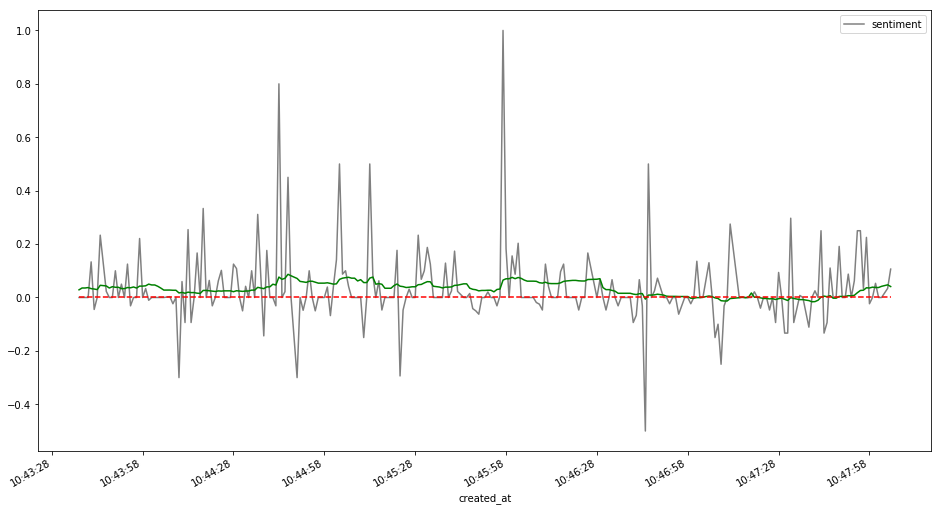

In [593]:
rcParams['figure.figsize'] = 16, 9

dfS[-250:].plot(kind='line', color='grey')

ax1 = dfS['sentiment'].rolling(30, min_periods=1).mean()[-250:].plot(kind='line', color='g')
plt.plot(dfS.index[-250:], [0]*len(dfS.index[-250:]), '--r')

## Let's try to answer question (2) now. What's the converation about?

In [568]:
stop = set(stopwords.words('english'))  # predefined list of "uninteresting" words

counter = Counter()

def nlargest(n, word_scores):
    """ Wrapper around heapq to return the n words with the largest count."""
    # word_scores: index 0=>word, 1=>count
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

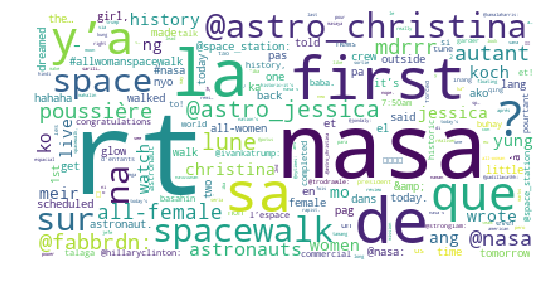

In [595]:
rcParams['figure.figsize'] = 9, 6
DISPLAY_EVERY = 100

try:
    for k in range(len(L)):
        try:
            tweet = L[k]['text']
            for word in tweet.lower().split():
                if word not in stop and 'http' not in word:
                    counter[word] += 1
            if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
                wordcloud = WordCloud(background_color='white'#, collocations=False #, 
                                      #width=1600, height=800
                                     ).fit_words(counter)
                plt.axis("off")
                display.clear_output(wait=True)
                plt.imshow(wordcloud)
                display.display(plt.gcf())
        except:
            pass
    display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [596]:
nlargest(10, counter.items())

[('rt', 15789),
 ('nasa', 8173),
 ('la', 3758),
 ('de', 3611),
 ('first', 3176),
 ('sa', 2961),
 ('?', 2084),
 ('que', 2065),
 ('y‚Äôa', 1987),
 ('@astro_christina', 1973)]

In [597]:
#L = [x for x in L if x]

### Is there more than one topic?

In [598]:
#Collect only the tweets
T = []
for tweet in L:
    T.append(tweet['text'])

In [607]:
BATCH_SIZE = 100
CLUSTER_SIZE = 4

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([next(batchiter)], batchiter)

In [608]:
with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }

In [609]:
def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(Counter({k:v for (k,v) in dict(counts).items() if v > 0})) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()

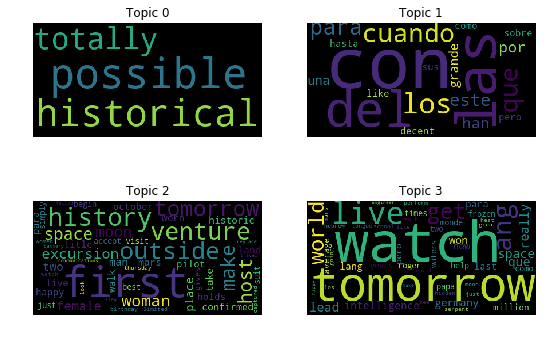

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [610]:
try:
    for tweets in batch(T, BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [nlargest(50, zip(words, kmeans.cluster_centers_[i])) for i in range(kmeans.n_clusters)]
        wordclouds(wordcounts)
except:
    pass

### Let's move on to question (3): Can we build a few profiles based on information provided by users in their description?

In [611]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['user_description'].dropna().drop_duplicates())

In [612]:
X.shape

(9076, 27543)

In [616]:
print(vectorizer.get_feature_names()[1000:1020])

['aew', 'af', 'af_academy', 'afar', 'afasto', 'afb', 'afdnazis', 'afeta', 'afetado', 'afeto', 'affairs', 'affaler', 'affections', 'affective', 'affects', 'affiches', 'afficionado', 'affiliate', 'affiliated', 'affiliates']


In [617]:
dfDBS = df['user_description'].dropna().drop_duplicates().reset_index()

In [618]:
clustering = DBSCAN(eps=.5, min_samples=3).fit(X)

In [619]:
dfDBS['dbscan'] = clustering.labels_

In [672]:
dfDBS['dbscan'].unique()

array([-1,  0,  1,  2,  3,  4,  5, 11,  6,  7,  8,  9, 10, 12])

In [669]:
dfDBS[dfDBS['dbscan'] == 1]

index user_description  dbscan
621     823            Happy       1
7478   9858            happy       1
8645  11405          Happy üòä       1

In [673]:
for l in range(1,dfDBS['dbscan'].unique().max()):
    print(dfDBS[dfDBS['dbscan'] == l])

    t = list(df.loc[list(dfDBS[dfDBS['dbscan'] == l]['index'])]['text'])
    for a in t:
        print(a)
    print('\n')

      index user_description  dbscan
621     823            Happy       1
7478   9858            happy       1
8645  11405          Happy üòä       1
RT @NASA: Even though they were designed for a two-year mission, our Van Allen Probes lasted for about seven years in one of the harshest e‚Ä¶
RT @troobie_md: Dahil puro students at teachers lang ang nasa loob, heto kami sa labas! Thanks po uli sa generous sponsors namin! To God be‚Ä¶
RT @MsM1995: Nasa EB si @mainedcm!üòç

#IsaPaFeelGoodWeekend
#MaineMendoza

 https://t.co/grmvel2hJj


      index user_description  dbscan
897    1175          Simple‚ù§       2
2004   2602           simple       2
8429  11123       Simple....       2
RT @jeyynuhhhh: saana ol breakfast in bed ü•∫‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è https://t.co/PhXtjN8ILa
RT @MDyey21: @chefgoosegirl @panotsha @aldenrichards02 Maganda ung Ikaw Pala. Though I'm really waiting for the other one. Yung nasa dining‚Ä¶
RT @DLorania: Nasa Top trends a din,siya waiting nalang sa mga Big Account 



## Let's move on to my favorite part, geospatial analysis!! And let's try to answer question (4): Where (in the physical world) are people tweeting from and of those locations which ones have a higher engagement?

*We extracted the location information from the tweets that had it so let's see how many did.*

In [674]:
df.location.dropna()

1336    {'type': 'Point', 'coordinates': [112.72278627...
3457    {'type': 'Point', 'coordinates': [121.05386257...
6462    {'type': 'Point', 'coordinates': [-78.8962636,...
Name: location, dtype: object

In [676]:
#df = df.drop(3350, axis=0)

## That's not very promising. What else can we do to get geospatial information? We can look into the 'place' key.

In [677]:
df.place.dropna()

248      {'id': '3b77caf94bfc81fe', 'url': 'https://api...
249      {'id': '0087ad0f1b6dfcc8', 'url': 'https://api...
267      {'id': '3b77caf94bfc81fe', 'url': 'https://api...
313      {'id': '01516da6022dca08', 'url': 'https://api...
321      {'id': '521b6f591c4b3ce8', 'url': 'https://api...
377      {'id': '006523c50dfe9086', 'url': 'https://api...
459      {'id': '01e93ed535e05b29', 'url': 'https://api...
485      {'id': '013379ee5729a5e6', 'url': 'https://api...
661      {'id': '07d9ec9cc0086001', 'url': 'https://api...
778      {'id': '3797791ff9c0e4c6', 'url': 'https://api...
868      {'id': '01d7c74272e5eafe', 'url': 'https://api...
961      {'id': '5579f6b17e36847b', 'url': 'https://api...
1012     {'id': '003d47f62835a9f1', 'url': 'https://api...
1063     {'id': '00fc4c873d8a5e32', 'url': 'https://api...
1094     {'id': 'd6819fe60643ebc1', 'url': 'https://api...
1117     {'id': '4ec01c9dbc693497', 'url': 'https://api...
1155     {'id': '0fa65e5e6fbf3eb8', 'url': 'https://api.

In [678]:
df.place.loc[248]

{'id': '3b77caf94bfc81fe',
 'url': 'https://api.twitter.com/1.1/geo/id/3b77caf94bfc81fe.json',
 'place_type': 'city',
 'name': 'Los Angeles',
 'full_name': 'Los Angeles, CA',
 'country_code': 'US',
 'country': 'United States',
 'bounding_box': {'type': 'Polygon',
  'coordinates': [[[-118.668404, 33.704538],
    [-118.668404, 34.337041],
    [-118.155409, 34.337041],
    [-118.155409, 33.704538]]]},
 'attributes': {}}

## Not all tweets have a 'place' key but there are definitely more of those than with a location. Inside 'place' there are coordinates for a geographical bounding box so let's compute its centroid and use that as a point of reference for location.

In [679]:
df1 = df[['place', 'text']].dropna().reset_index()
df1['centroid_lat'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0], 1)
df1['centroid_lon'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1], 1)

df1 = df1.groupby(['centroid_lat', 'centroid_lon'])['text'].count().reset_index()
df1.columns = ['centroid_lat', 'centroid_lon', 'count']

#### What are the most common centroids?

In [680]:
df1.sort_values(by='count', ascending=False)

centroid_lat  centroid_lon  count
80     120.983987     14.591457      6
4     -118.411907     34.020789      3
46     -73.968542     40.780709      3
40     -77.014398     38.898603      3
84     121.033212     14.546499      3
56      -3.703508     40.477795      2
25     -83.804475     27.698682      2
65      24.830963     65.862802      2
52     -46.595546    -23.682803      2
81     121.006950     14.532882      2
86     121.062736     14.683012      2
29     -81.197276     28.588445      2
28     -81.854561     41.419246      2
88     121.082345     14.583306      2
2     -122.330602     47.614817      2
101    122.147242      7.175473      1
72      91.594285     22.897541      1
79     120.969501     14.430456      1
109    135.512242     35.008375      1
78     120.818031     13.984376      1
77     120.728789     15.192721      1
76     120.588440     16.402280      1
75     112.724706     -7.275803      1
74     106.745736     -6.186236      1
110    138.792756    -35.097686      1
73     104.016823      1.050769      1
71      72.098744     34.062818      1
100    121.484736     14.435230      1
70      55.551172     24.993462      1
69      50.573873     25.952302      1
..            ...           ...    ...
6     -111.931711     34.168253      1
5     -117.730006     33.560742      1
3     -119.827182     39.512436      1
30     -80.737633     28.258804      1
31     -80.650764     28.586010      1
32     -80.201097     44.080757      1
47     -73.789133      5.108820      1
58      -2.136197     49.245837      1
57      -3.203009     55.943196      1
1     -122.555439     38.093358      1
55      -6.395316     52.957956      1
54      -8.422813     43.345661      1
53     -43.441578    -22.911422      1
51     -47.436633    -23.470006      1
50     -49.288460    -25.495249      1
49     -66.058368     18.384166      1
48     -71.683502     42.036939      1
45     -74.278855     40.266520      1
33     -79.861034     35.170499      1
44     -74.315005     40.569527      1
43     -75.483936     40.591825      1
42     -75.699457     39.736777      1
41     -75.770041     42.746617      1
39     -77.090869     38.817380      1
38     -78.855078     35.723200      1
37     -79.272570     43.629311      1
36     -79.420865     38.003376      1
35     -79.428376     43.903509      1
34     -79.674847     44.371263      1
112    153.369361    -27.954221      1

[113 rows x 3 columns]

### Where are users located according to their bios?

In [682]:
df.groupby('user_location')['text'].count().sort_values(ascending=False).reset_index()

user_location  text
0        Republic of the Philippines   161
1                      United States   159
2                    Los Angeles, CA    64
3                                USA    52
4                             France    50
5                      Paris, France    49
6                    California, USA    45
7                       New York, NY    43
8                     Washington, DC    41
9                        Philippines    34
10                        Texas, USA    31
11                      Florida, USA    31
12                         Worldwide    30
13                                üáµüá≠    28
14             Ile-de-France, France    28
15                             Earth    27
16                         Venezuela    27
17                   London, England    27
18                       Chicago, IL    24
19       Comunidad de Madrid, Espa√±a    23
20                       Houston, TX    23
21                         Australia    22
22                      Lyon, France    22
23                             India    19
24                     San Diego, CA    18
25                 San Francisco, CA    18
26                            Canada    18
27                           Florida    17
28                        Weiser, ID    17
29                   Berlin, Germany    16
...                              ...   ...
4793            Sorocaba - S√£o Paulo     1
4794                          Sonora     1
4795       Sonoma County, California     1
4796        Son Seung-Wan's garbage‚Ñ¢     1
4797                    Somolu Lagos     1
4798                  Somewhere, USA     1
4799   Somewhere, Over the Rainbow üåà     1
4800                   Somewhere, OK     1
4801        Somewhere you don't know     1
4802     Somewhere over the Rainbow      1
4803              Somewhere on Earth     1
4804            Somewhere on Azeroth     1
4805          Somewhere in the Earth     1
4806       Somewhere between nowhere     1
4807                  Smashville, TN     1
4808      Somewhere behind the lines     1
4809    Somewhere Playing the Ponies     1
4810             Somewhere Out There     1
4811   Somewhere I can‚Äôt be found...     1
4812          Somerton, Philadelphia     1
4813                Somebody's babe      1
4814              Some Cooling Place     1
4815                Somalia|Ethiopia     1
4816   Somalia, Kenya, United States     1
4817   Sol, Sector 0, Alpha Quadrant     1
4818                           Sol 3     1
4819          Sof√° do Central Perk ‚òï     1
4820                          So Cal     1
4821                  Smithville, MO     1
4822  Northeast PA/Broad Channel, NY     1

[4823 rows x 2 columns]

In [684]:
# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for index, row in df.iterrows():
    try:
        
        #location = geolocator.geocode(user_loc)
        # If coordinates are found for location
        if row['location']['coordinates']:
            coordinates['latitude'].append(row['location']['coordinates'][0])
            coordinates['longitude'].append(row['location']['coordinates'][1])
            
    # If too many connection requests
    except:
        pass

In [685]:
coordinates

{'latitude': [112.72278627, 121.05386257, -78.8962636],
 'longitude': [-7.27586109, 14.62204492, 35.7372126]}

### Lets now map the information we have from tweet's location and bounding box centroids.

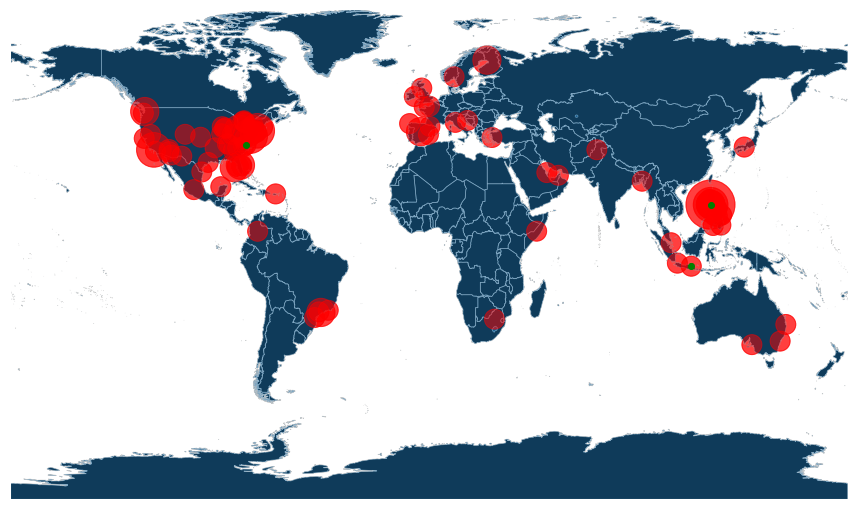

In [686]:
shp_link = './ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
shp = ps.open(shp_link)
some = [True for i in ps.open(shp_link)] #bool(rdm.getrandbits(1))


fig = figure(figsize=(15,9))

base = maps.map_poly_shp(shp)
base.set_facecolor('black')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')
some = maps.map_poly_shp(shp, which=some)
some.set_alpha(0.5)
some.set_linewidth(0.)
ptsC = scatter(df1['centroid_lat'], df1['centroid_lon'], s=400*df1['count'], alpha=.5)
ptsC.set_color('red')

pts = scatter(coordinates['latitude'], coordinates['longitude'])
pts.set_color('green')

ax = maps.setup_ax([base, some, ptsC, pts], [shp.bbox, shp.bbox, shp.bbox, shp.bbox])

fig.add_axes(ax)
show()

# Thank you!

In [594]:
#df.to_csv('dataT.csv', index=False)

In [66]:
#dfA = pd.read_csv('dataT.csv')

In [70]:
def Converter(x):
    try:
        return eval(x)
    except:
        None

In [71]:
#dfA['raw_data'] = dfA.apply(lambda x: Converter(x['raw_data']), 1)

In [74]:
#L = list(dfA['raw_data']) + L

In [ ]:
#L = [x for x in L if x]